# MIDI Feature Exploration Template

This notebook demonstrates how to stream classical MIDI files from Hugging Face, extract musical features, and run exploratory analyses.


In [1]:
# Uncomment the following line the first time you run this notebook
%pip install datasets pretty_midi numpy scipy pandas scikit-learn seaborn requests


Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("/Users/eddiebae/CS/math50-final-project")
if PROJECT_ROOT.exists() and str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))


In [3]:
from pathlib import Path

import pandas as pd
from datasets import Dataset
from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from src.data import extract_features_from_dataset, load_hf_dataset
from src.features import extract_midi_features


In [4]:
# Dataset configuration is defined in the next cell.


In [5]:
DATASET_NAME = "drengskapur/midi-classical-music"
DATASET_SPLIT = "train"
OUTPUT_PATH = Path("data/processed/midi_composer_features.csv")
MAX_ITEMS = None  # set to None to process full split
RESOLVE_BASE_URL = f"https://huggingface.co/datasets/{DATASET_NAME}/resolve/main/"


# Helper to extract composer from URL (dataset specific)
def composer_from_url(url: str) -> str:
    parts = url.split("/")
    if "data" in parts:
        data_idx = parts.index("data")
        if data_idx + 1 < len(parts):
            return parts[data_idx + 1]
    return parts[-2]



In [6]:
dataset: Dataset = load_hf_dataset(
    DATASET_NAME,
    split=DATASET_SPLIT,
    streaming=True,
)
dataset


IterableDataset({
    features: ['file_name'],
    num_shards: 1
})

In [ ]:
def stream_features():
    progress = tqdm(total=MAX_ITEMS, disable=MAX_ITEMS is None, desc="MIDI files")

    def update(count):
        progress.n = count
        progress.refresh()

    for result in extract_features_from_dataset(
        dataset,
        extract_midi_features,
        max_items=MAX_ITEMS,
        composer_from_url=composer_from_url,
        progress_callback=update,
        base_url=RESOLVE_BASE_URL,
    ):
        yield {**result.metadata, **result.features}

    progress.close()


records = list(stream_features())
len(records)


/Users/anaconda3/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [ ]:
df = pd.DataFrame.from_records(records)
df.head()


,file_url,composer,duration_sec,tempo_mean,tempo_std,pitch_range,pitch_mean,pitch_variance,note_duration_mean,note_duration_variance,note_density,polyphony,rhythmic_entropy,pitch_class_entropy
0,https://huggingface.co/datasets/drengskapur/mi...,albeniz-aragon_fantasia_op47_part_6.mid,259.909700,63.250036,21.738538,73.0,70.443467,129.597935,0.217449,0.036471,12.250409,2.515,2.314356,3.311626
1,https://huggingface.co/datasets/drengskapur/mi...,albeniz-castilla_seguidillas_op47_part_7.mid,209.332316,104.833397,11.090759,81.0,68.430185,139.077480,0.198159,0.022898,10.571707,1.845,1.718311,3.428109
2,https://huggingface.co/datasets/drengskapur/mi...,albeniz-cataluna_courranda_no2_from_suite_espa...,207.304274,130.509450,27.920122,60.0,62.755009,124.185881,0.357107,0.205957,10.593125,3.745,1.960237,3.193609
3,https://huggingface.co/datasets/drengskapur/mi...,albeniz-cataluna_courranda_no2_from_suite_espa...,271.234048,113.546747,7.580009,65.0,63.914261,130.830794,0.364737,0.110944,8.428145,3.010,1.674710,3.143899
4,https://huggingface.co/datasets/drengskapur/mi...,albeniz-espana_op_165.mid,95.192394,117.756071,15.413741,64.0,68.069401,146.165531,0.316985,0.103793,6.660196,2.050,2.651790,2.964964


In [ ]:
top_composers = df["composer"].value_counts().head(8).index.tolist()
df_top = df[df["composer"].isin(top_composers)].copy()
df_top["composer"] = df_top["composer"].astype("category")
top_composers


['albeniz-aragon_fantasia_op47_part_6.mid',
 'bach-bwv001-_400_chorales-011704v2.mid',
 'bach-bwv001-_400_chorales-011007b.mid',
 'bach-bwv001-_400_chorales-011106b.mid',
 'bach-bwv001-_400_chorales-011205b.mid',
 'bach-bwv001-_400_chorales-011308b.mid',
 'bach-bwv001-_400_chorales-011407b.mid',
 'bach-bwv001-_400_chorales-011506b.mid']

In [ ]:
df_top["composer"].value_counts()


composer
albeniz-aragon_fantasia_op47_part_6.mid    1
bach-bwv001-_400_chorales-011007b.mid      1
bach-bwv001-_400_chorales-011106b.mid      1
bach-bwv001-_400_chorales-011205b.mid      1
bach-bwv001-_400_chorales-011308b.mid      1
bach-bwv001-_400_chorales-011407b.mid      1
bach-bwv001-_400_chorales-011506b.mid      1
bach-bwv001-_400_chorales-011704v2.mid     1
Name: count, dtype: int64

In [ ]:
OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(OUTPUT_PATH, index=False)
OUTPUT_PATH


PosixPath('data/processed/midi_composer_features.csv')

In [ ]:
df_top.groupby("composer").agg({
    "pitch_class_entropy": "mean",
    "rhythmic_entropy": "mean",
    "polyphony": "mean",
    "note_density": "mean",
    "pitch_mean": "mean",
    "pitch_variance": "mean",
    "note_duration_mean": "mean",
    "note_duration_variance": "mean",
}).sort_values("pitch_class_entropy", ascending=False)


/var/folders/p2/cdj69_b90yd1md9r563bvt8w0000gn/T/ipykernel_28295/3087865892.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_top.groupby("composer").agg({


,pitch_class_entropy,rhythmic_entropy,polyphony,note_density,pitch_mean,pitch_variance,note_duration_mean,note_duration_variance
composer,,,,,,,,
albeniz-aragon_fantasia_op47_part_6.mid,3.311626,2.314356,2.515,12.250409,70.443467,129.597935,0.217449,0.036471
bach-bwv001-_400_chorales-011308b.mid,3.067365,1.135984,3.980,7.125000,62.757895,70.850157,0.535088,0.095397
bach-bwv001-_400_chorales-011704v2.mid,3.025348,1.255257,4.975,9.300004,59.950000,95.808611,0.510752,0.038444
bach-bwv001-_400_chorales-011106b.mid,3.002453,1.390690,4.015,6.723810,61.104816,55.702895,0.578966,0.158474
bach-bwv001-_400_chorales-011407b.mid,2.996229,1.429061,3.980,7.275007,60.398625,59.524947,0.522336,0.045797
bach-bwv001-_400_chorales-011007b.mid,2.916395,1.192628,3.980,6.866667,64.150485,68.516189,0.546117,0.043080
bach-bwv001-_400_chorales-011205b.mid,2.897851,1.081429,6.830,13.440000,63.119048,54.962018,0.485491,0.040337
bach-bwv001-_400_chorales-011506b.mid,2.892668,0.981214,4.975,9.514286,57.741742,90.587957,0.525526,0.100225


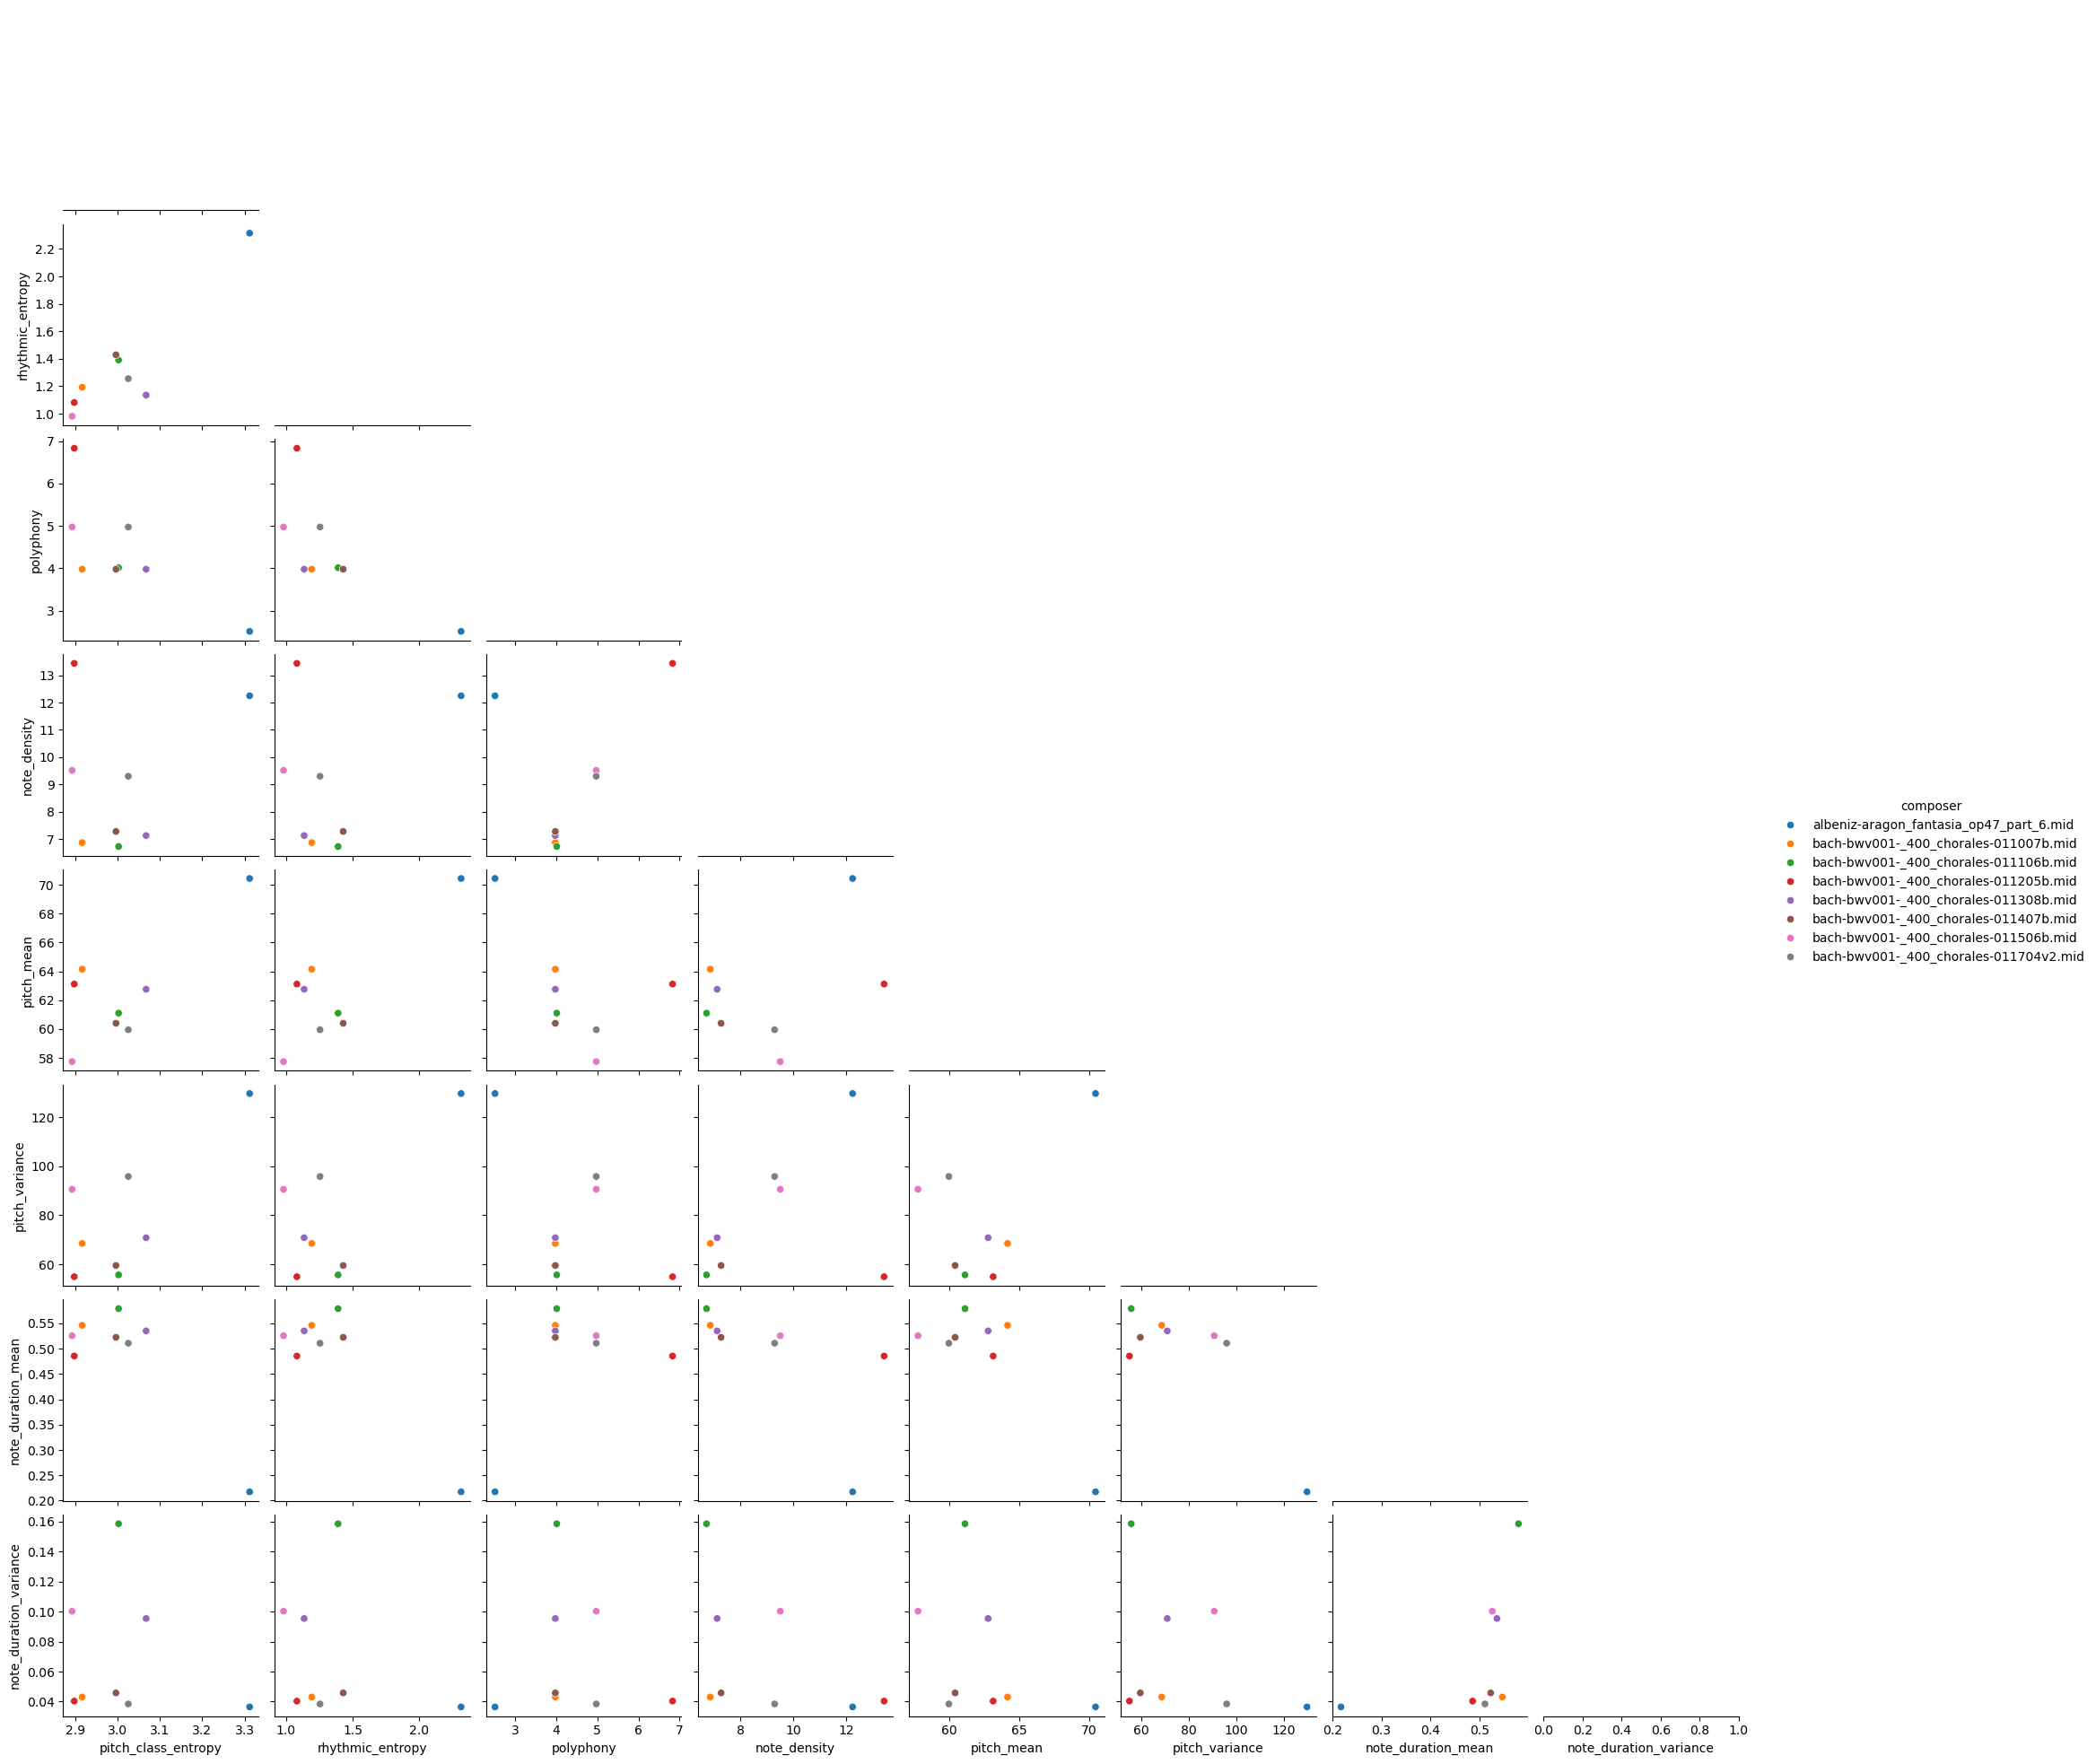

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(
    df_top,
    vars=[
        "pitch_class_entropy",
        "rhythmic_entropy",
        "polyphony",
        "note_density",
        "pitch_mean",
        "pitch_variance",
        "note_duration_mean",
        "note_duration_variance",
    ],
    hue="composer",
    corner=True,
)
plt.show()


## Linear Regression for Composer Indicators

We model each composer as a separate regression target (one-hot encoded) to see how well the eight handcrafted features explain stylistic differences.


In [ ]:
FEATURE_COLUMNS = [
    "pitch_class_entropy",
    "rhythmic_entropy",
    "polyphony",
    "note_density",
    "pitch_mean",
    "pitch_variance",
    "note_duration_mean",
    "note_duration_variance",
]

X = df_top[FEATURE_COLUMNS]
y = pd.get_dummies(df_top["composer"], dtype=float)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=df_top["composer"],
)

regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

coefficients = pd.DataFrame(
    regression_model.coef_,
    columns=FEATURE_COLUMNS,
    index=y.columns,
)
coefficients


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
y_pred = pd.DataFrame(
    regression_model.predict(X_test),
    columns=y.columns,
    index=y_test.index,
)

predicted_labels = y_pred.idxmax(axis=1)
true_labels = y_test.idxmax(axis=1)

composer_accuracy = (predicted_labels == true_labels).mean()

print(f"Hold-out accuracy (argmax over linear outputs): {composer_accuracy:.3f}")

y_pred.assign(true_label=true_labels, predicted_label=predicted_labels).head()


Hold-out accuracy (argmax over linear outputs): 1.000


,data,true_label,predicted_label
21,1.0,data,data
87,1.0,data,data
71,1.0,data,data
1,1.0,data,data
167,1.0,data,data


In [ ]:
# Linear regression on tempo using the same feature set
FEATURE_COLUMNS = [
    "pitch_class_entropy",
    "rhythmic_entropy",
    "polyphony",
    "note_density",
    "pitch_mean",
    "pitch_variance",
    "note_duration_mean",
    "note_duration_variance",
]
TARGET_COLUMN = "tempo_mean"

X = df_top[FEATURE_COLUMNS].fillna(0)
y = df_top[TARGET_COLUMN].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R^2:", r2_score(y_test, y_pred))
pd.DataFrame(
    {
        "feature": FEATURE_COLUMNS,
        "coefficient": model.coef_,
    }
)


R^2: 0.0766801449985286


,feature,coefficient
0,pitch_class_entropy,-32.916823
1,rhythmic_entropy,-9.785291
2,polyphony,-12.838160
3,note_density,3.675721
4,pitch_mean,0.311102
5,pitch_variance,0.030913
6,note_duration_mean,31.175056
7,note_duration_variance,-8.712647


## One-vs-Rest Binary Classifiers

We also evaluate each composer individually by fitting logistic regression models that distinguish that composer from the rest using the same handcrafted features.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

binary_results = []

for composer in top_composers:
    y_binary = (df_top["composer"] == composer).astype(int)
    positives = int(y_binary.sum())
    negatives = int(len(y_binary) - positives)

    if positives < 3 or negatives < 3:
        binary_results.append(
            {
                "composer": composer,
                "accuracy": None,
                "roc_auc": None,
                "notes": f"Insufficient samples after filtering (positives={positives}, negatives={negatives})",
            }
        )
        continue

    try:
        X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
            X,
            y_binary,
            test_size=0.2,
            random_state=42,
            stratify=y_binary,
        )
    except ValueError:
        binary_results.append(
            {
                "composer": composer,
                "accuracy": None,
                "roc_auc": None,
                "notes": "Train/test split failed to preserve both classes",
            }
        )
        continue

    if y_train_bin.nunique() < 2 or y_test_bin.nunique() < 2:
        binary_results.append(
            {
                "composer": composer,
                "accuracy": None,
                "roc_auc": None,
                "notes": "Split resulted in single-class train/test data",
            }
        )
        continue

    log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
    log_reg.fit(X_train_bin, y_train_bin)

    y_pred_bin = log_reg.predict(X_test_bin)
    y_proba_bin = log_reg.predict_proba(X_test_bin)[:, 1]

    binary_results.append(
        {
            "composer": composer,
            "accuracy": accuracy_score(y_test_bin, y_pred_bin),
            "roc_auc": roc_auc_score(y_test_bin, y_proba_bin),
            "notes": "OK",
        }
    )

pd.DataFrame(binary_results).sort_values("roc_auc", ascending=False)


,composer,accuracy,roc_auc,notes
0,data,None,None,Insufficient samples after filtering (positive...


In [ ]:
composer_counts = df_top["composer"].value_counts()
composer_train_counts = y_train.groupby(df_top.loc[y_train.index, "composer"]).size()
composer_test_counts = y_test.groupby(df_top.loc[y_test.index, "composer"]).size()

summary = pd.DataFrame({
    "total": composer_counts,
    "train": composer_train_counts,
    "test": composer_test_counts,
}).fillna(0).astype(int)
summary


/var/folders/p2/cdj69_b90yd1md9r563bvt8w0000gn/T/ipykernel_25240/1767317111.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  composer_train_counts = y_train.groupby(df_top.loc[y_train.index, "composer"]).size()
/var/folders/p2/cdj69_b90yd1md9r563bvt8w0000gn/T/ipykernel_25240/1767317111.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  composer_test_counts = y_test.groupby(df_top.loc[y_test.index, "composer"]).size()


,total,train,test
composer,,,
data,200,160,40


## Next Steps

- Tune `MAX_ITEMS` and experiment with different composers (ensure at least 8 have sufficient data).
- Compare the composer-indicator regression with other classifiers (e.g., logistic regression, complex-valued networks).
- Extend `extract_midi_features` with additional descriptors and rerun the regression analyses to quantify improvements.
